In [1]:
import numpy as np
from scipy.integrate import quad
from ler import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/phurailatpamhemantakumar/anaconda3/envs/lal/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
ler = LeR(npool=int(4),z_min=0., z_max=5., batch_size=25000,
    m_min=1., 
    m_max=2.4,
    event_type='BNS',
    spin_zero=True,
    mtot_min=2., 
    mtot_max=18., 
    nsamples_mtot=50, 
    nsamples_mass_ratio=100, 
    sampling_frequency=2048.,
    waveform_approximant = 'TaylorF2', 
    minimum_frequency = 20., 
    snr_type = 'interpolation', 
    waveform_inspiral_must_be_above_fmin=False,
    interpolator_dir="../interpolator_pickle")

Given: Inspiral waveform, TaylorF2.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ../interpolator_pickle/L1/halfSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ../interpolator_pickle/H1/halfSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ../interpolator_pickle/V1/halfSNR_dict_1.pickle


In [3]:
# sample unlensed parameters
ler.batch_size = 25000
ler.unlensed_cbc_statistics(nsamples=100000, json_file="./unlensed_params_BNS_gwcosmo.json");

chosen batch size = 25000. If you want to change batch size, self.batch_size = new_size
There will be 4 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
Batch no. 2
sampling gw source params...
calculating snrs...
Batch no. 3
sampling gw source params...
calculating snrs...
Batch no. 4
sampling gw source params...
calculating snrs...


In [8]:
# rates
unlensed_rate = ler.unlensed_rate(gw_param='./unlensed_params_BNS_gwcosmo.json',
    snr_threshold=8.0,
    jsonfile='./unlensed_params_detectable_BNS_gwcosmo.json',)

getting gw_params from json file ./unlensed_params_BNS_gwcosmo.json...
total unlensed rate (yr^-1) (with step function): 2.9998313333562048
storing detectable unlensed params in ./unlensed_params_detectable_BNS_gwcosmo.json


In [9]:
# sample lensed parameters
lensed_param = ler.lensed_cbc_statistics(nsamples=100000, json_file="./lensed_params_BNS_gwcosmo.json");

chosen batch size = 25000. If you want to change batch size, self.batch_size = new_size
There will be 4 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4614.49it/s]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4629.63it/s]


calculating snrs...
Batch no. 3
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4601.57it/s]


calculating snrs...
Batch no. 4
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4618.30it/s]


calculating snrs...


In [11]:
# lensed rates
lensed_rate = ler.lensed_rate(lensed_param='./lensed_params_BNS_gwcosmo.json',
    jsonfile='./lensed_params_detectable_BNS_gwcosmo.json',)

getting lensed_param from json file ./lensed_params_BNS_gwcosmo.json...
total lensed rate (yr^-1) (with step function): 0.005273090718219792
storing detectable lensed params in ./lensed_params_detectable_BNS_gwcosmo.json...


In [12]:
ler.rate_comparision();

unlensed_rate: 2.9998313333562048
lensed_rate: 0.005273090718219792
ratio: 568.8943152430639


## 4 image case

In [13]:
# detectable lensed events
f = open('lensed_params_BNS_gwcosmo.json', "r")
lensed_param = json.loads(f.read())

### When all image srns are combine

In [14]:
# selecting 4 image case
mag = np.array(lensed_param['magnifications'])
snr = np.array(lensed_param["opt_snr_net"])
# checking if each row of snr contains nan
snr_nan = np.isnan(mag)
# sum each row
snr_nan_sum = np.sum(snr_nan, axis=1)
# boolean array for snr_nan_sum == 0
snr_4image = snr_nan_sum == 0

# selection
snr = snr[snr_4image]

In [15]:
snr_threshold = 8.
# squared and add up snr in each row, and then take sqrt
snr = snr**2
snr_sum = np.sum(snr, axis=1)
snr_sum = np.sqrt(snr_sum)

# boolean array for snr_sum > snr_threshold
snr_hit = snr_sum > snr_threshold

# rejection sample wrt to weights
weights = np.array(lensed_param["weights"])[snr_4image]
not_rejected = np.random.uniform(0, 1, len(weights)) < weights
snr_hit = snr_hit & not_rejected

print("total snr hits: ", np.sum(snr_hit))

total snr hits:  26


### When only 4 of the snrs are considered seperately

In [16]:
# for 1M samples
# Dimensions are (nsamples, n_max_images)
snr = np.array(lensed_param["opt_snr_net"])
snr = np.array(snr[snr_4image])
size = len(snr)
snr_threshold = 8.

# if nan in snr, set snr to 0
snr[np.isnan(snr)] = 0.

# if the highest and second highest are greater than 8, then set snr as True
"""snr_hit = np.full(len(snr), True)
snr = np.sort(snr, axis=1)
snr_hit = snr_hit & (snr[:, -1] > snr_threshold) & (snr[:, -2] > snr_threshold)"""
snr_hit = snr>8
snr_hit = np.sum(snr_hit,axis=1)

# rejection sample wrt to weights
weights = np.array(lensed_param["weights"])[snr_4image]
not_rejected = np.random.uniform(0, 1, size) < weights
snr_hit = snr_hit & not_rejected

print("total snr hits: ", np.sum(snr_hit))

total snr hits:  4


In [17]:
26/4

6.5

# Plots

In [18]:
lensed_param.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'e1', 'e2', 'gamma1', 'gamma2', 'Dl', 'Ds', 'Dls', 'theta_E', 'gamma', 'mass_1', 'mass_2', 'mass_1_source', 'mass_2_source', 'luminosity_distance', 'iota', 'psi', 'phase', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'n_images', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'weights', 'opt_snr_net', 'L1', 'H1', 'V1'])

In [19]:
mass_1_source = lensed_param['mass_1_source']
mass_2_source = lensed_param['mass_2_source']

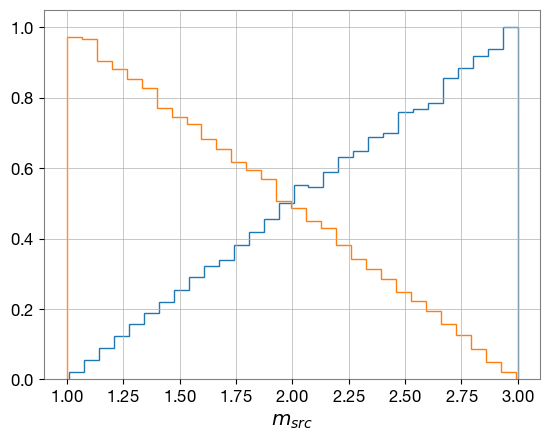

In [20]:
plt.hist(mass_1_source, histtype='step', density=True, bins=30, label="mass1")
plt.hist(mass_2_source, histtype='step', density=True, bins=30, label="mass2")
plt.xlabel(r'$m_{src}$')
plt.show()

In [4]:
# detectable lensed events
f = open('unlensed_params_BNS_gwcosmo.json', "r")
unlensed_param = json.loads(f.read())

In [5]:
mass_1_source = unlensed_param['mass_1_source']
mass_2_source = unlensed_param['mass_2_source']

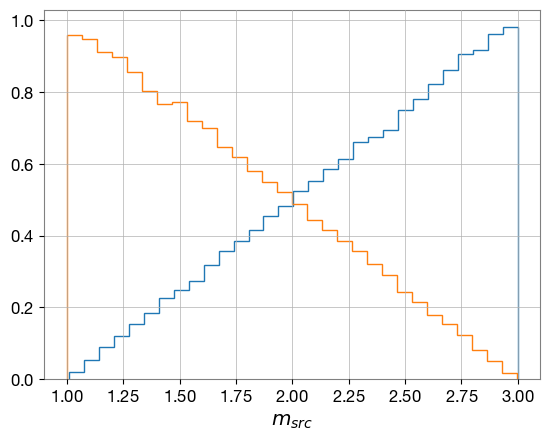

In [6]:
plt.hist(mass_1_source, histtype='step', density=True, bins=30, label="mass1")
plt.hist(mass_2_source, histtype='step', density=True, bins=30, label="mass2")
plt.xlabel(r'$m_{src}$')
plt.show()